# Выводы:  
Согласно заданию, варьировались следующие параметры: `batch_size`, `lr`, `num_epochs`.   
Обучение моделей проводилось на пратформе Google Colab (Tesla T4)
Во всех экспериментах, кроме иходного, использовалась техника уменьшения `lr` во время обучения.  
Выявлены следующие закономерности:  
 - Если `lr > 0.05`, модель попадает в локальный минимум, из которого не удаётся выбраться даже при уменьшении `lr` на следующих эпохах, из-за чего итоговая мерика accuracy не превышает 46%  
 - увеличение размера `batch_size` негативно сказывается на метрике, но зато ускоряет обучение. Тем не менее, использование `batch_size` выше 1024 нецелесообразно, т к время обучения почти не меняется, а точность слегка падает.
 - уменьшение `batch_size` с 32 до 16 позволило повысить `accuracy` на 1-2%, но скорость обучение одной эпохи возрасла с 63 скеунд до 110 секунд

Согласно полученным результатам, оптимальные параметры следующие: `batch_size=64`, `lr=0.05` с последующим домножением на 0.5 каждые 7 эпох  
Ниже приведены параметры моделей и графики измнения `train_loss`, `valid_loss`, `accuracy`

Параметр `milestones` отвечает за то, на какой эпохе параметр `lr` умножается на `gamma`


# Исходная модель:
```python
num_epochs = 20
batch_size = 32
learning_rate = 0.001
```
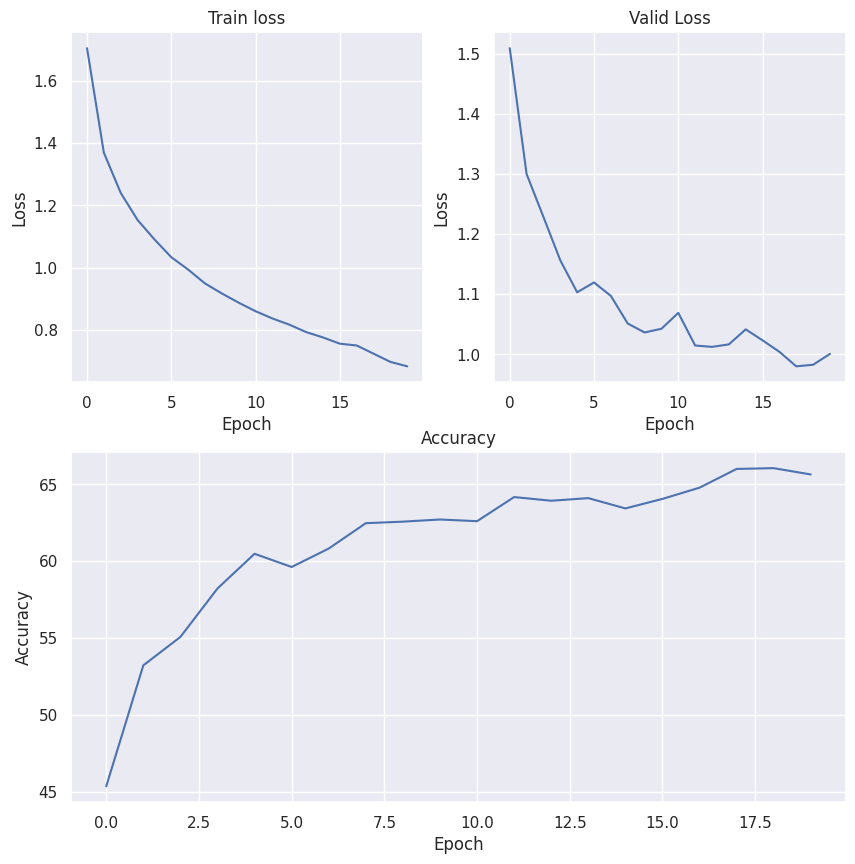  
 
# Модифицированные модели:
## 1
```python
num_epochs = 30
batch_size = 512
learning_rate = 0.01
milestones=[10, 20]
gamma=0.1
```
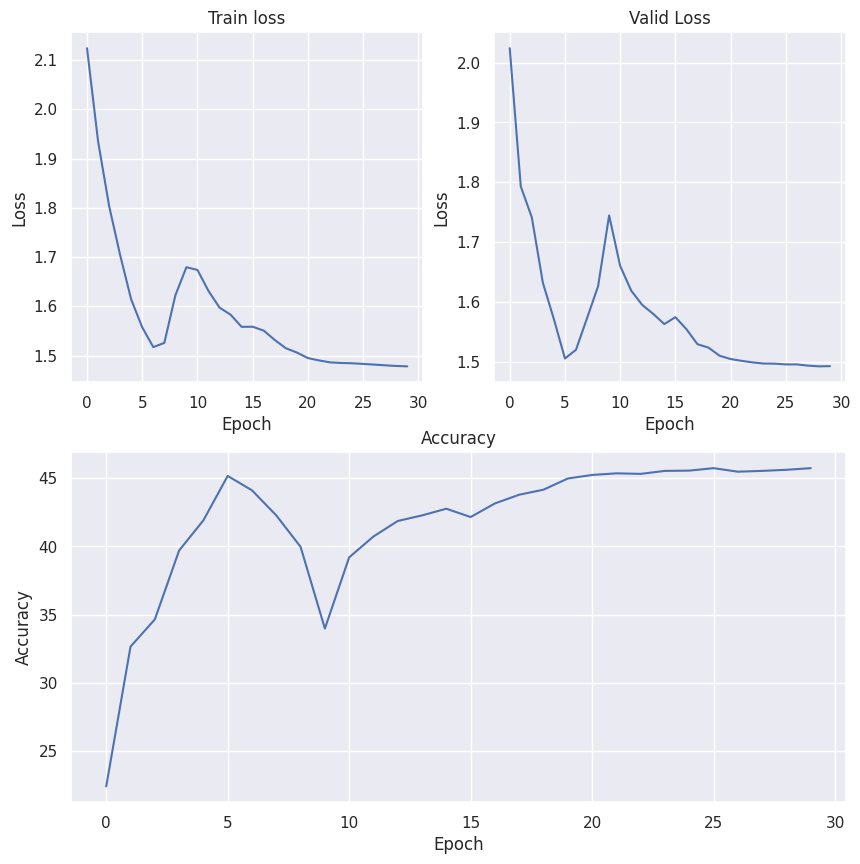

## 2
```python
num_epochs = 25
batch_size = 2048
learning_rate = 0.001
milestones=[10, 20]
gamma=0.1
```
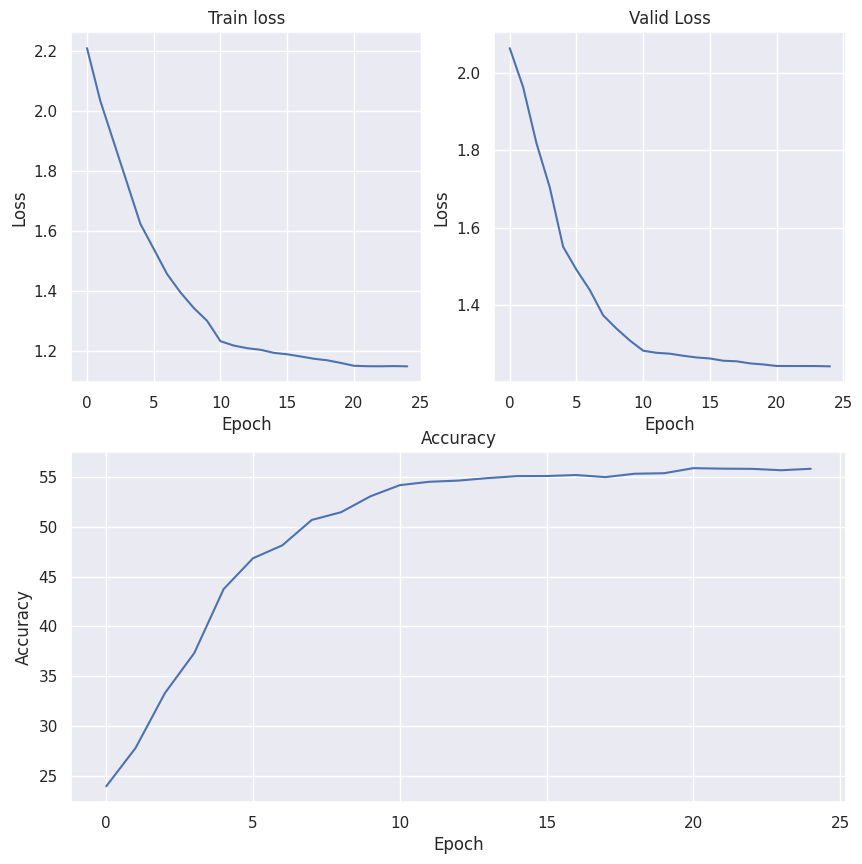

## 3
```python
num_epochs = 20
batch_size = 64
learning_rate = 0.001
milestones=[7, 15]
gamma=0.1
```
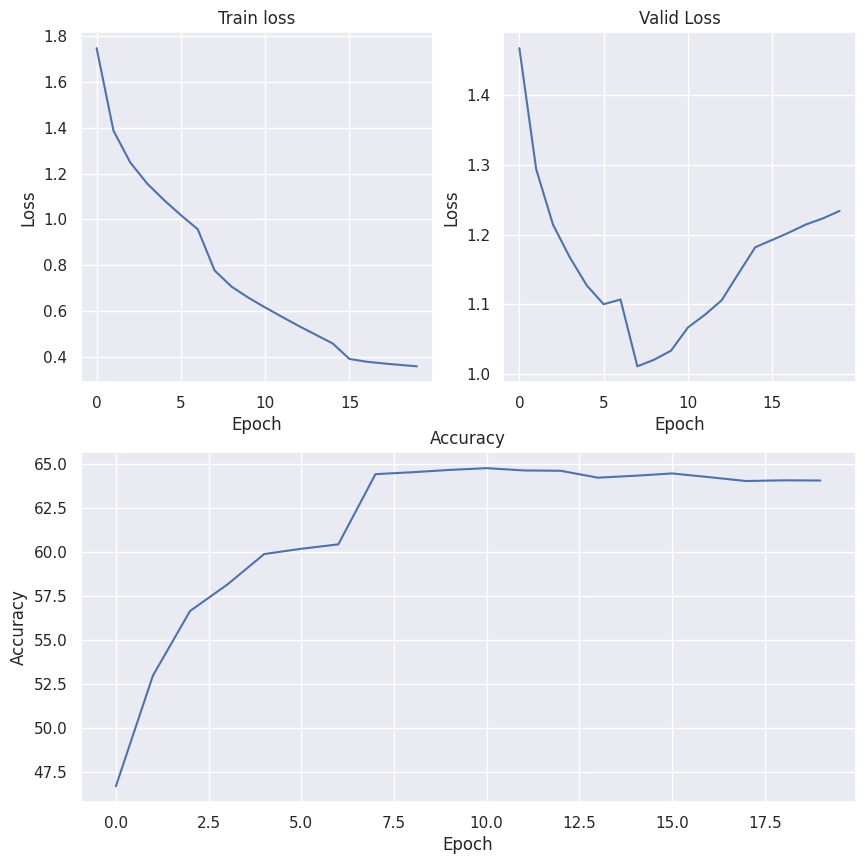

## 4
```python
num_epochs = 20
batch_size = 256
learning_rate = 0.005
milestones=[5, 10, 15]
gamma=0.5
```
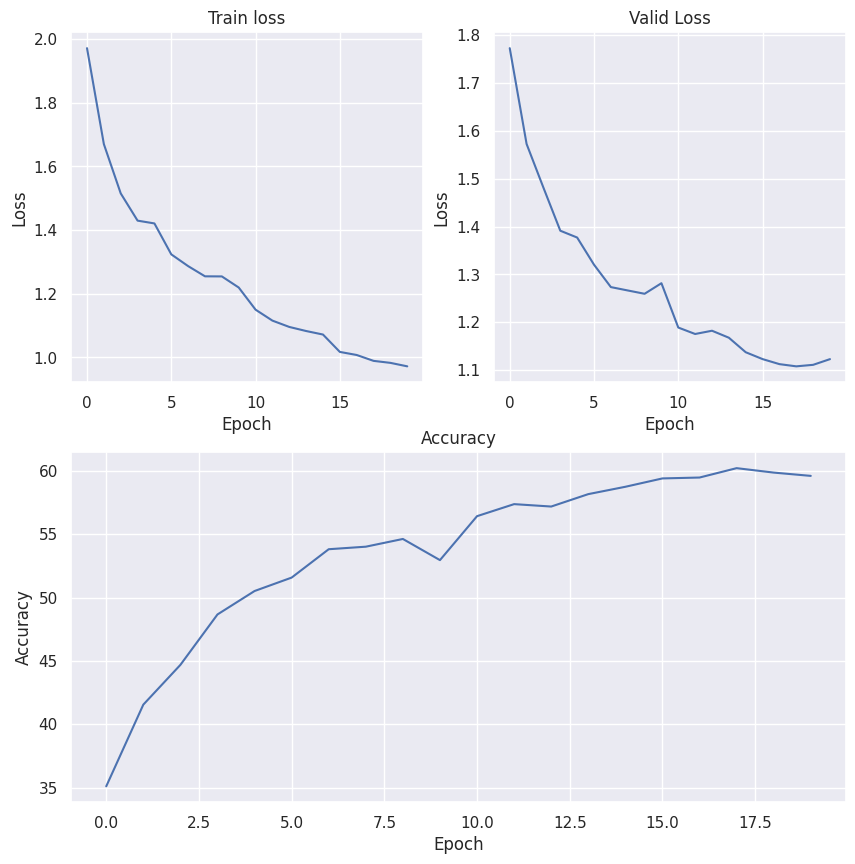

## 5
```python
num_epochs = 25
batch_size = 16
learning_rate = 0.001
milestones=[7, 14, 20]
gamma=0.5
```
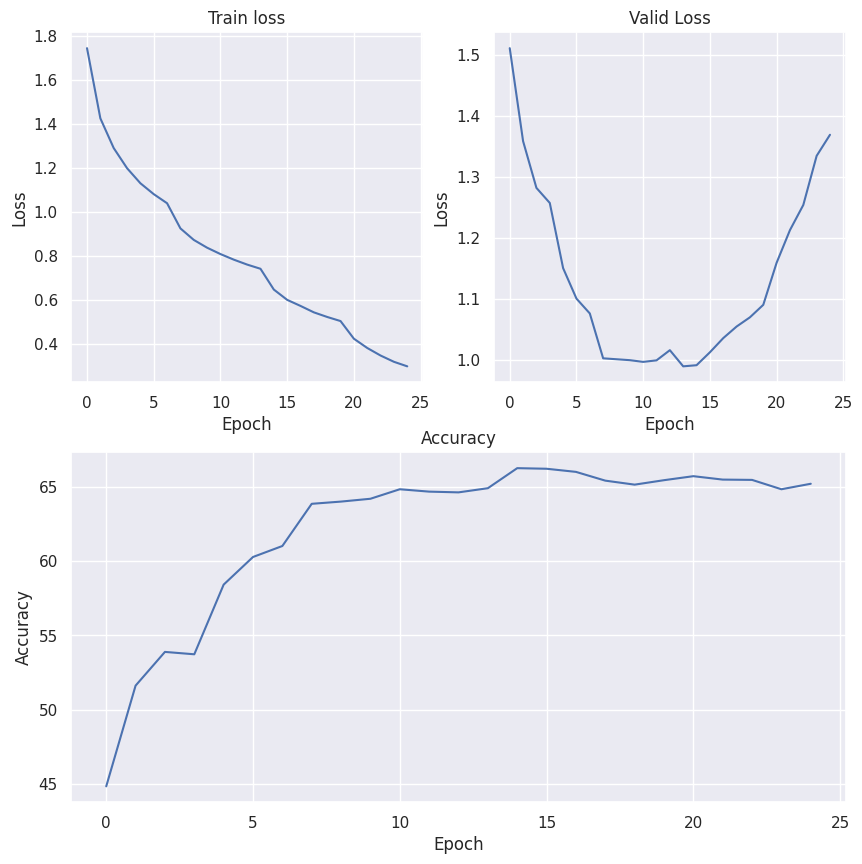

# Исходный код

In [1]:
!%pip install seaborn
!%pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import Tensor, nn
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.cuda.amp import autocast, GradScaler

import os
from time import time

from tqdm import tqdm

import seaborn as sns
import numpy as np
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#препроцессинг
trans = Compose([
    Resize((224, 224)),
    ToTensor(),
])

# Architecture

In [5]:
#создается последовательность эмбедингов, которые являются входом
# кодировщика
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16,
        emb_size: int = 768,img_size: int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size,
            stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        ) # разбивает изображение на патчи s1xs2, а затем сглаживает их
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        #self.positions = nn.Parameter(torch.randn(1, x.shape[1],
        # self.embedding_dim))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)
        **2 + 1, emb_size))
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #добавляет эмбединги позиций
        x += self.positions
        return x


In [6]:
#механизм внимания
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):

        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3) # queries, keys and
        # values matrix
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d",
        h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) #
        # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # sum over the third axis
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [7]:
#shortcut connection
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [8]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, L: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, L * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(L * emb_size, emb_size),
        )


In [9]:
#в целом весь transformer encoder блок
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0.,
        forward_expansion: int = 4,
        forward_drop_p: float = 0.,
        **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                emb_size, L=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )


In [10]:
#несколько encoder блоков
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [11]:
#классификатор
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )


In [12]:
#vision transformer
class ViT(nn.Sequential):
    def __init__(self,
        in_channels: int = 3,
        patch_size: int = 16,
        emb_size: int = 768,
        img_size: int = 224,
        depth: int = 12,
        n_classes: int = 1000,
        **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [13]:
summary(ViT(), (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

# Dataset

In [14]:
# Загружаем CIFAR-10 датасет, преобразуем размер и нормализируем
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47393222.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Train eval pipeline

In [15]:
class SchedulerPlaceholder:
    def __init__(self, lr):
        self.lr = lr

    def get_last_lr(self):
        return self.lr

    def step(self):
        pass

In [16]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scaler,
                 train_loader, valid_loader,
                 batch_size, device, num_epochs, scheduler=None, DEFAULT_MODEL_PATH="./models/default_moddel.pth"):
        # Model
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scaler = scaler
        if scheduler is not None:
            self.scheduler = scheduler
        else:
            self.scheduler = SchedulerPlaceholder(optimizer.param_groups[0]['lr'])
        self.DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH
        # datasets
        self.train_loader = train_loader
        self.valid_loader= valid_loader

        # Params
        self.num_epochs = num_epochs
        self.batch_size = batch_size

        # Device
        self.device = device

        self.train_losses = []
        self.valid_losses = []
        self.valid_acc = []

    def _train(self, current_epoch):
        total_loss = []
        start_time = time()
        self.model.train()
        for data, targets in self.train_loader:
            data = data.to(device=self.device)
            targets = targets.to(device=self.device)

            outputs = self.model(data)

            loss = self.criterion(outputs, targets)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            total_loss.append(loss.item())

        mean_total_loss = np.mean(total_loss)
        self.train_losses.append(mean_total_loss)
        print(f"Epoch: {current_epoch}/{self.num_epochs}, time: {int(time() - start_time)}s, lr = {self.scheduler.get_last_lr()}\n\tTrain loss: {mean_total_loss:.2f}")

    def _valid(self, current_epoch):
        total_loss = []
        total_samples = 0
        total_correct = 0
        self.model.eval()
        with torch.no_grad():
            for data, targets in self.valid_loader:

                data = data.to(device=self.device)
                targets = targets.to(device=self.device)

                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                # Forward
                scores = self.model(data)

                loss = self.criterion(scores, targets)
                total_loss.append(loss.item())

                total_samples += targets.size(0)
                total_correct += (predicted == targets).sum().item()
        accuracy = total_correct / total_samples * 100
        self.valid_acc.append(accuracy)

        mean_total_loss = np.mean(total_loss)
        self.valid_losses.append(mean_total_loss)

        print(f"\tValid loss: {mean_total_loss:.2f}, Accuracy: {accuracy:.2f}")

    def fit(self):
        for epoch in range(self.num_epochs):
            self._train(epoch + 1)
            self._valid(epoch + 1)
            self.scheduler.step()
        torch.save(self.model.to("cpu").state_dict(), self.DEFAULT_MODEL_PATH)


    def plot_graph(self):
        sns.set_theme()
        fig = plt.figure(figsize=(10, 10))
        spec = gridspec.GridSpec(ncols=2, nrows=2)
        train_ax = fig.add_subplot(spec[0, 0])
        valid_ax = fig.add_subplot(spec[0, 1])
        acc_ax = fig.add_subplot(spec[1, :])
        # fig.suptitle('Loss')

        train_ax.set_title("Train loss")
        valid_ax.set_title("Valid Loss")
        acc_ax.set_title("Accuracy")

        train_ax.set_ylabel('Loss')
        valid_ax.set_ylabel('Loss')
        acc_ax.set_ylabel("Accuracy")

        train_ax.set_xlabel("Epoch")
        valid_ax.set_xlabel("Epoch")
        acc_ax.set_xlabel("Epoch")

        sns.lineplot(data=self.train_losses, ax=train_ax)
        sns.lineplot(data=self.valid_losses, ax=valid_ax)
        sns.lineplot(data=self.valid_acc, ax=acc_ax)

        plt.show()


# Default model

In [ ]:
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=1)

In [ ]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()


In [ ]:
# Обучение модели
DEFAULT_MODEL_PATH = "./models/default_moddel.pth"
fit_model = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=None, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [ ]:
fit_model.fit()

Epoch: 1/20, time: 65s, lr = 0.001
	Train loss: 1.71
	Valid loss: 1.51, Accuracy: 45.36
Epoch: 2/20, time: 65s, lr = 0.001
	Train loss: 1.37
	Valid loss: 1.30, Accuracy: 53.23
Epoch: 3/20, time: 64s, lr = 0.001
	Train loss: 1.24
	Valid loss: 1.23, Accuracy: 55.08
Epoch: 4/20, time: 64s, lr = 0.001
	Train loss: 1.15
	Valid loss: 1.16, Accuracy: 58.23
Epoch: 5/20, time: 63s, lr = 0.001
	Train loss: 1.09
	Valid loss: 1.10, Accuracy: 60.49
Epoch: 6/20, time: 65s, lr = 0.001
	Train loss: 1.03
	Valid loss: 1.12, Accuracy: 59.63
Epoch: 7/20, time: 65s, lr = 0.001
	Train loss: 0.99
	Valid loss: 1.10, Accuracy: 60.83
Epoch: 8/20, time: 66s, lr = 0.001
	Train loss: 0.95
	Valid loss: 1.05, Accuracy: 62.48
Epoch: 9/20, time: 67s, lr = 0.001
	Train loss: 0.92
	Valid loss: 1.04, Accuracy: 62.58
Epoch: 10/20, time: 65s, lr = 0.001
	Train loss: 0.89
	Valid loss: 1.04, Accuracy: 62.72
Epoch: 11/20, time: 65s, lr = 0.001
	Train loss: 0.86
	Valid loss: 1.07, Accuracy: 62.61
Epoch: 12/20, time: 65s, lr = 

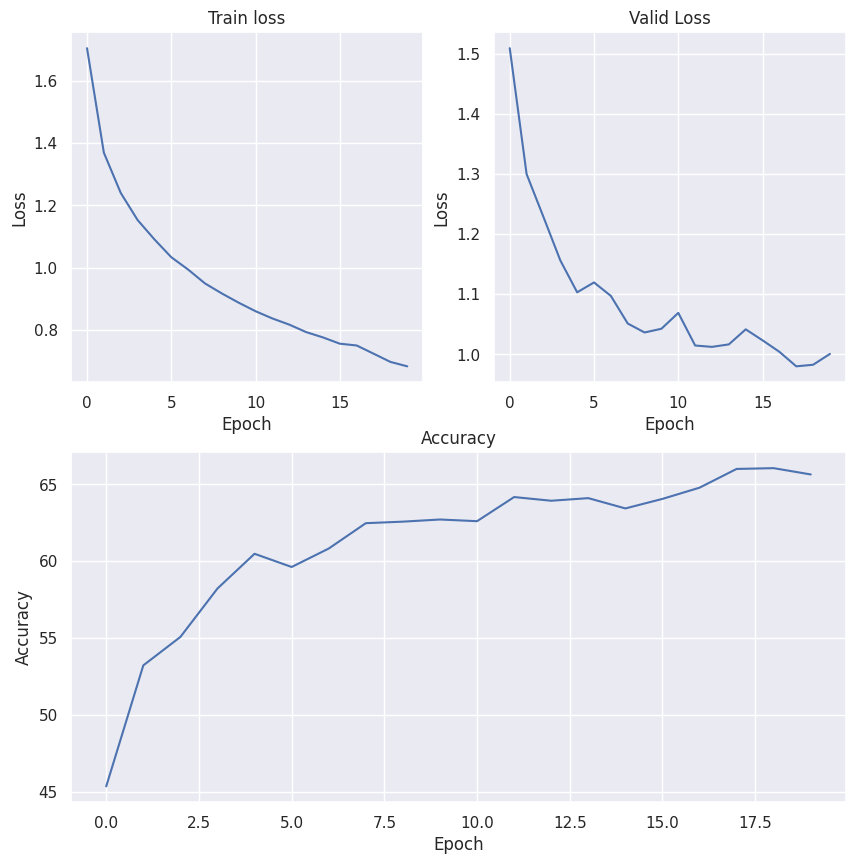

In [ ]:
fit_model.plot_graph()

# Modified Model 1

In [ ]:
num_epochs = 30
batch_size = 512
learning_rate = 0.01

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [ ]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) # StepLR

In [ ]:
DEFAULT_MODEL_PATH = "./models/modified_model.pth"
fit_model2 = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=scheduler, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [ ]:
fit_model2.fit()

Epoch: 1/30, time: 38s, lr = [0.01]
	Train loss: 2.12
	Valid loss: 2.02, Accuracy: 22.38
Epoch: 2/30, time: 34s, lr = [0.01]
	Train loss: 1.94
	Valid loss: 1.79, Accuracy: 32.64
Epoch: 3/30, time: 36s, lr = [0.01]
	Train loss: 1.80
	Valid loss: 1.74, Accuracy: 34.64
Epoch: 4/30, time: 35s, lr = [0.01]
	Train loss: 1.70
	Valid loss: 1.63, Accuracy: 39.70
Epoch: 5/30, time: 35s, lr = [0.01]
	Train loss: 1.61
	Valid loss: 1.57, Accuracy: 41.92
Epoch: 6/30, time: 35s, lr = [0.01]
	Train loss: 1.56
	Valid loss: 1.51, Accuracy: 45.18
Epoch: 7/30, time: 35s, lr = [0.01]
	Train loss: 1.52
	Valid loss: 1.52, Accuracy: 44.12
Epoch: 8/30, time: 35s, lr = [0.01]
	Train loss: 1.53
	Valid loss: 1.57, Accuracy: 42.28
Epoch: 9/30, time: 35s, lr = [0.01]
	Train loss: 1.62
	Valid loss: 1.63, Accuracy: 39.97
Epoch: 10/30, time: 35s, lr = [0.01]
	Train loss: 1.68
	Valid loss: 1.74, Accuracy: 33.97
Epoch: 11/30, time: 34s, lr = [0.001]
	Train loss: 1.67
	Valid loss: 1.66, Accuracy: 39.20
Epoch: 12/30, time

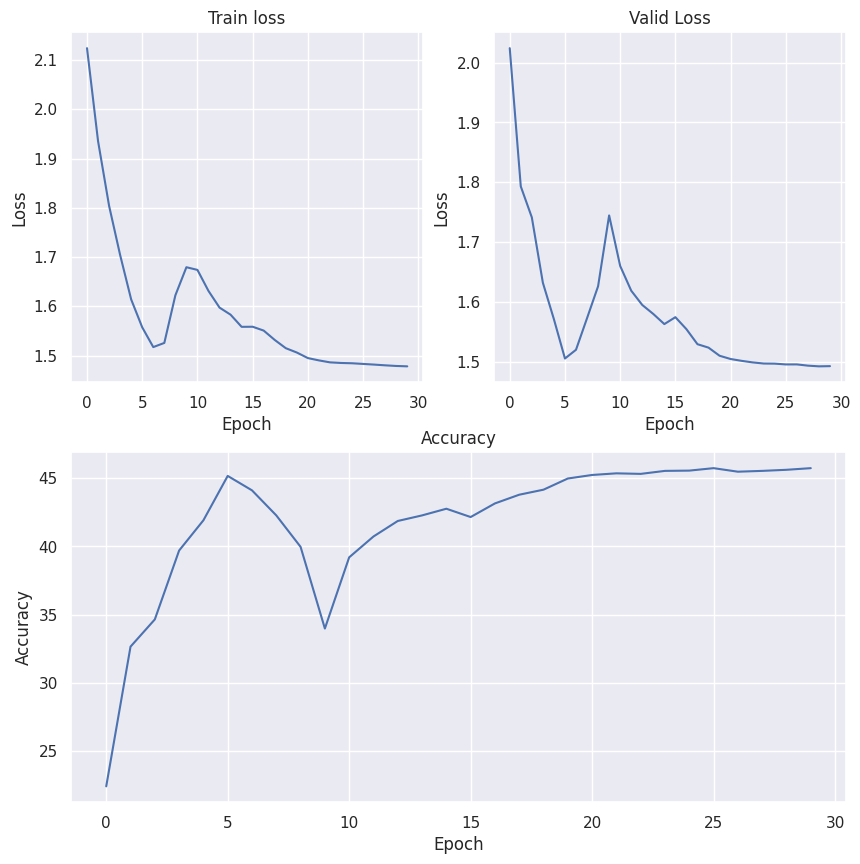

In [ ]:
fit_model2.plot_graph()

# Modified Model 2

In [ ]:
num_epochs = 25
batch_size = 2048
learning_rate = 0.001

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [ ]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) # StepLR

In [ ]:
DEFAULT_MODEL_PATH = "./models/modified_model2.pth"
fit_model2 = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=scheduler, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [ ]:
fit_model2.fit()

Epoch: 1/25, time: 35s, lr = [0.001]
	Train loss: 2.21
	Valid loss: 2.06, Accuracy: 23.91
Epoch: 2/25, time: 35s, lr = [0.001]
	Train loss: 2.03
	Valid loss: 1.96, Accuracy: 27.77
Epoch: 3/25, time: 35s, lr = [0.001]
	Train loss: 1.90
	Valid loss: 1.82, Accuracy: 33.29
Epoch: 4/25, time: 36s, lr = [0.001]
	Train loss: 1.76
	Valid loss: 1.70, Accuracy: 37.32
Epoch: 5/25, time: 35s, lr = [0.001]
	Train loss: 1.62
	Valid loss: 1.55, Accuracy: 43.75
Epoch: 6/25, time: 35s, lr = [0.001]
	Train loss: 1.54
	Valid loss: 1.49, Accuracy: 46.85
Epoch: 7/25, time: 35s, lr = [0.001]
	Train loss: 1.46
	Valid loss: 1.44, Accuracy: 48.15
Epoch: 8/25, time: 36s, lr = [0.001]
	Train loss: 1.39
	Valid loss: 1.37, Accuracy: 50.70
Epoch: 9/25, time: 35s, lr = [0.001]
	Train loss: 1.34
	Valid loss: 1.34, Accuracy: 51.48
Epoch: 10/25, time: 36s, lr = [0.001]
	Train loss: 1.30
	Valid loss: 1.31, Accuracy: 53.08
Epoch: 11/25, time: 35s, lr = [0.0001]
	Train loss: 1.23
	Valid loss: 1.28, Accuracy: 54.20
Epoch: 

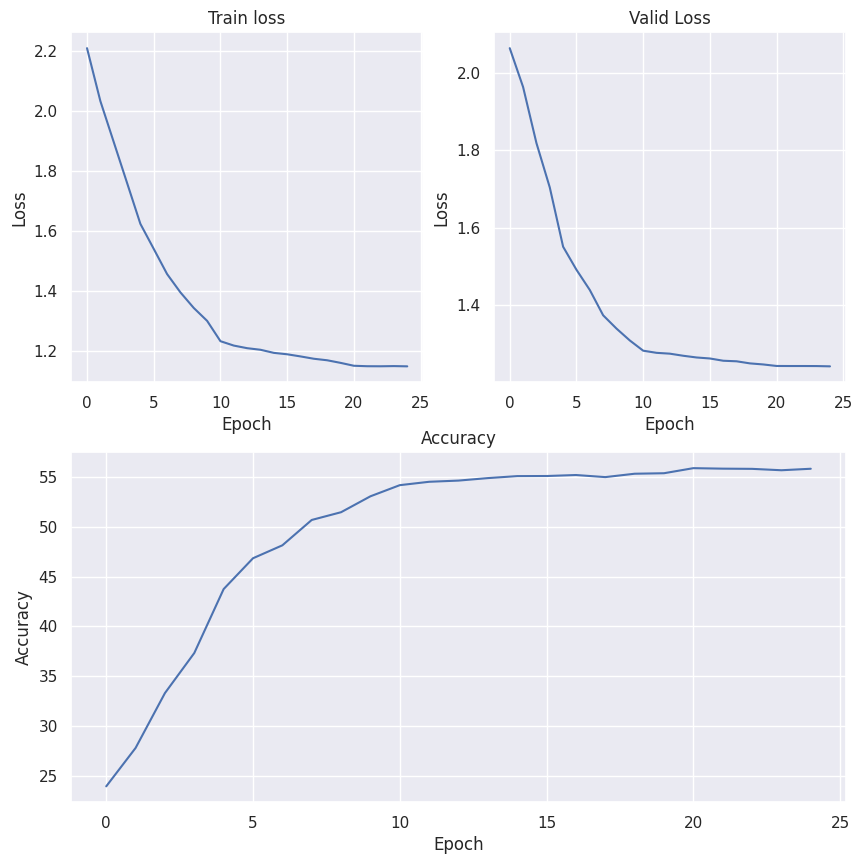

In [ ]:
fit_model2.plot_graph()

# Modified model 3

In [ ]:
num_epochs = 20
batch_size = 64
learning_rate = 0.001

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [ ]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7, 15], gamma=0.1) # StepLR

In [ ]:
DEFAULT_MODEL_PATH = "./models/modified_model3.pth"
fit_model2 = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=scheduler, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [ ]:
fit_model2.fit()

Epoch: 1/20, time: 39s, lr = [0.001]
	Train loss: 1.75
	Valid loss: 1.47, Accuracy: 46.70
Epoch: 2/20, time: 39s, lr = [0.001]
	Train loss: 1.39
	Valid loss: 1.29, Accuracy: 52.98
Epoch: 3/20, time: 39s, lr = [0.001]
	Train loss: 1.25
	Valid loss: 1.21, Accuracy: 56.64
Epoch: 4/20, time: 38s, lr = [0.001]
	Train loss: 1.16
	Valid loss: 1.17, Accuracy: 58.13
Epoch: 5/20, time: 39s, lr = [0.001]
	Train loss: 1.08
	Valid loss: 1.13, Accuracy: 59.87
Epoch: 6/20, time: 39s, lr = [0.001]
	Train loss: 1.02
	Valid loss: 1.10, Accuracy: 60.17
Epoch: 7/20, time: 38s, lr = [0.001]
	Train loss: 0.96
	Valid loss: 1.11, Accuracy: 60.42
Epoch: 8/20, time: 39s, lr = [0.0001]
	Train loss: 0.78
	Valid loss: 1.01, Accuracy: 64.40
Epoch: 9/20, time: 39s, lr = [0.0001]
	Train loss: 0.71
	Valid loss: 1.02, Accuracy: 64.51
Epoch: 10/20, time: 39s, lr = [0.0001]
	Train loss: 0.66
	Valid loss: 1.03, Accuracy: 64.64
Epoch: 11/20, time: 39s, lr = [0.0001]
	Train loss: 0.62
	Valid loss: 1.07, Accuracy: 64.74
Epoc

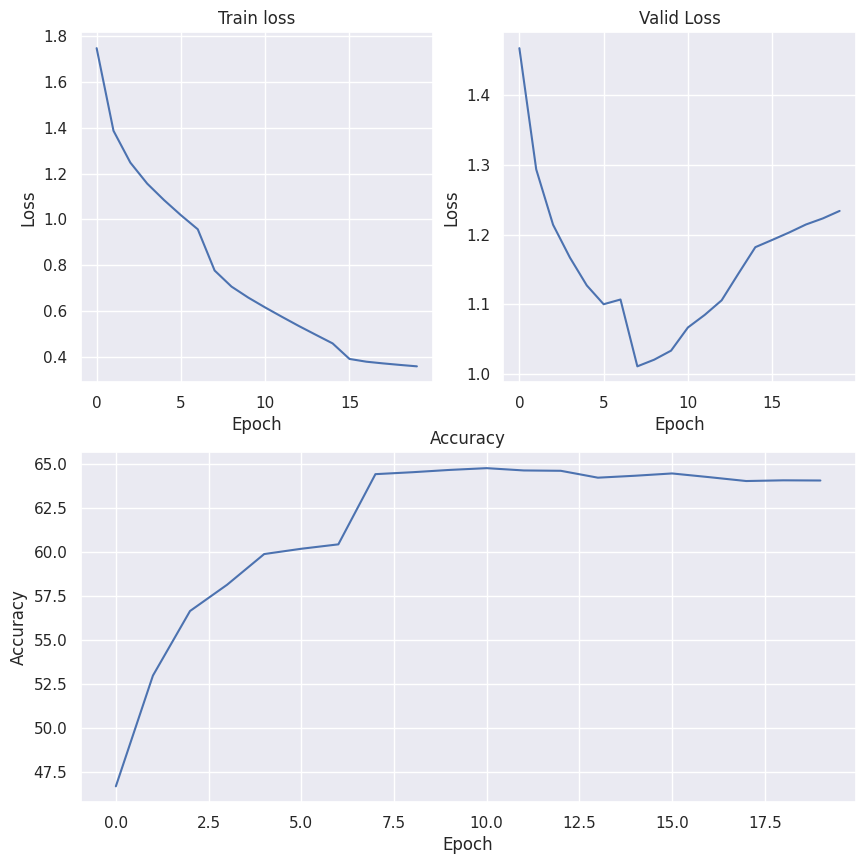

In [ ]:
fit_model2.plot_graph()

# Modified model 4

In [ ]:
num_epochs = 20
batch_size = 256
learning_rate = 0.005

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [ ]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.5) # StepLR

In [ ]:
DEFAULT_MODEL_PATH = "./models/modified_model4.pth"
fit_model4 = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=scheduler, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [ ]:
fit_model4.fit()

Epoch: 1/20, time: 36s, lr = [0.005]
	Train loss: 1.97
	Valid loss: 1.77, Accuracy: 35.11
Epoch: 2/20, time: 35s, lr = [0.005]
	Train loss: 1.67
	Valid loss: 1.57, Accuracy: 41.56
Epoch: 3/20, time: 36s, lr = [0.005]
	Train loss: 1.52
	Valid loss: 1.48, Accuracy: 44.70
Epoch: 4/20, time: 36s, lr = [0.005]
	Train loss: 1.43
	Valid loss: 1.39, Accuracy: 48.68
Epoch: 5/20, time: 36s, lr = [0.005]
	Train loss: 1.42
	Valid loss: 1.38, Accuracy: 50.53
Epoch: 6/20, time: 35s, lr = [0.0025]
	Train loss: 1.32
	Valid loss: 1.32, Accuracy: 51.59
Epoch: 7/20, time: 36s, lr = [0.0025]
	Train loss: 1.29
	Valid loss: 1.27, Accuracy: 53.83
Epoch: 8/20, time: 36s, lr = [0.0025]
	Train loss: 1.25
	Valid loss: 1.27, Accuracy: 54.03
Epoch: 9/20, time: 35s, lr = [0.0025]
	Train loss: 1.25
	Valid loss: 1.26, Accuracy: 54.64
Epoch: 10/20, time: 36s, lr = [0.0025]
	Train loss: 1.22
	Valid loss: 1.28, Accuracy: 52.97
Epoch: 11/20, time: 35s, lr = [0.00125]
	Train loss: 1.15
	Valid loss: 1.19, Accuracy: 56.44
E

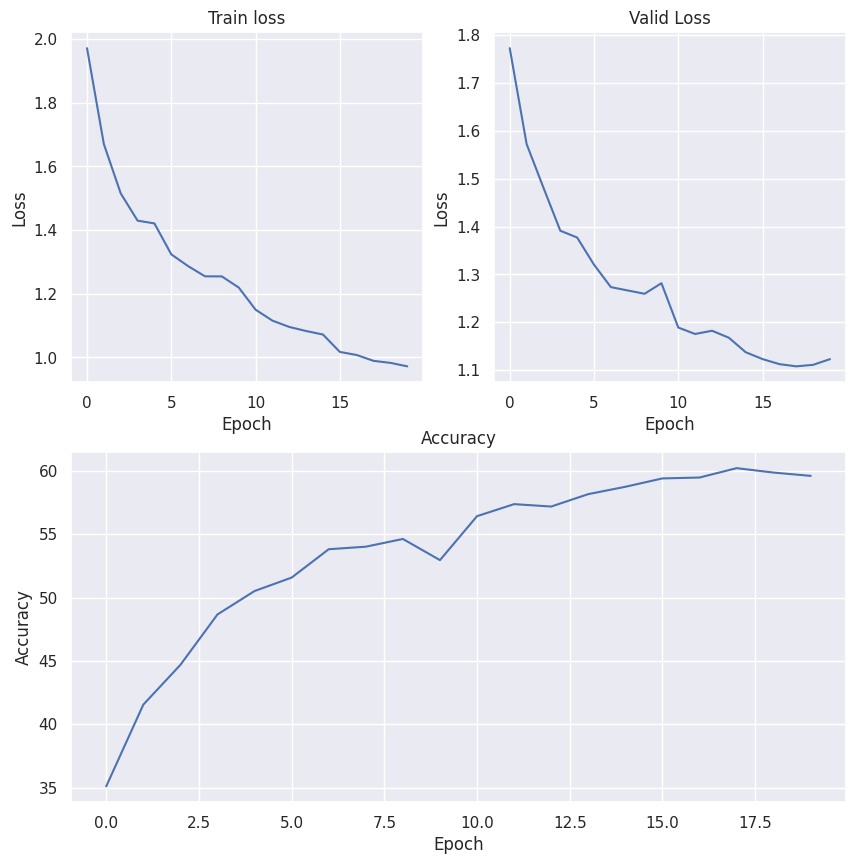

In [ ]:
fit_model4.plot_graph()

# Modified model 5

In [22]:
num_epochs = 25
batch_size = 16
learning_rate = 0.001

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [24]:
# Инициализируем модель и оптимизатор
#torch.cuda.empty_cache()
model = ViT(in_channels=3, patch_size=4, emb_size=64, img_size=32, depth=12, n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7, 14, 20], gamma=0.5) # StepLR

In [25]:
DEFAULT_MODEL_PATH = "./models/modified_model5.pth"
fit_model5 = FitModel(model, criterion, optimizer, scaler,
         train_loader, test_loader,
         batch_size, device, num_epochs,
         scheduler=scheduler, DEFAULT_MODEL_PATH=DEFAULT_MODEL_PATH)

In [26]:
fit_model5.fit()

Epoch: 1/25, time: 113s, lr = [0.001]
	Train loss: 1.74
	Valid loss: 1.51, Accuracy: 44.84
Epoch: 2/25, time: 113s, lr = [0.001]
	Train loss: 1.42
	Valid loss: 1.36, Accuracy: 51.62
Epoch: 3/25, time: 115s, lr = [0.001]
	Train loss: 1.29
	Valid loss: 1.28, Accuracy: 53.89
Epoch: 4/25, time: 115s, lr = [0.001]
	Train loss: 1.20
	Valid loss: 1.26, Accuracy: 53.73
Epoch: 5/25, time: 115s, lr = [0.001]
	Train loss: 1.13
	Valid loss: 1.15, Accuracy: 58.42
Epoch: 6/25, time: 114s, lr = [0.001]
	Train loss: 1.08
	Valid loss: 1.10, Accuracy: 60.28
Epoch: 7/25, time: 115s, lr = [0.001]
	Train loss: 1.04
	Valid loss: 1.08, Accuracy: 61.02
Epoch: 8/25, time: 112s, lr = [0.0005]
	Train loss: 0.92
	Valid loss: 1.00, Accuracy: 63.86
Epoch: 9/25, time: 111s, lr = [0.0005]
	Train loss: 0.87
	Valid loss: 1.00, Accuracy: 64.01
Epoch: 10/25, time: 111s, lr = [0.0005]
	Train loss: 0.84
	Valid loss: 1.00, Accuracy: 64.20
Epoch: 11/25, time: 112s, lr = [0.0005]
	Train loss: 0.81
	Valid loss: 1.00, Accuracy:

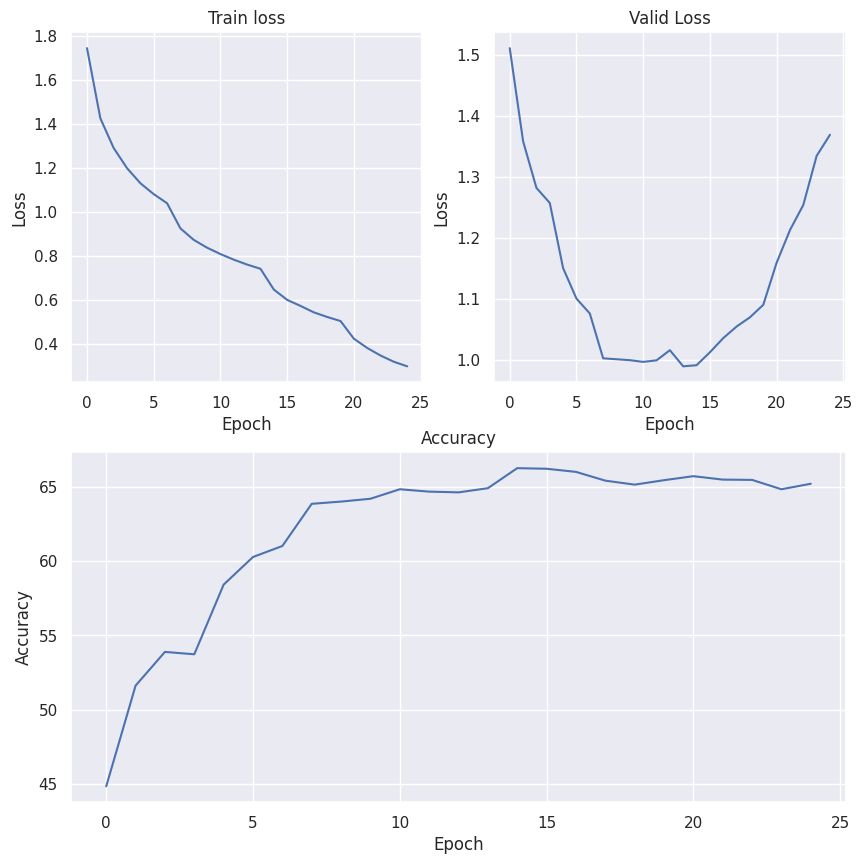

In [27]:
fit_model5.plot_graph()